In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model

# Load dataset
df = pd.read_csv("../data/cleaned_dataset.csv")

# Drop irrelevant columns with low correlation
columns_to_drop = [
    "Legislative District", 
    "Vehicle Location", 
    "Postal Code", 
    "City", 
    "2020 Census Tract", 
    "County", 
    "Electric Utility"
]

# Remove irrelevant columns
df = df.drop(columns=columns_to_drop)

# Filter out records where Electric Range is 0
df = df[df["Electric Range"] > 0]

# Define features and target
X = df.drop(columns=["Electric Range"]).fillna(df.mean(numeric_only=True))
y = df["Electric Range"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Residual block
def residual_block(x, units):
    shortcut = x
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dense(units)(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Model with residual connections
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = layers.Dense(128)(input_layer)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2)

# Evaluate
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae:.2f}")

Epoch 1/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1829.1063 - mae: 19.4218 - val_loss: 98.3137 - val_mae: 5.8743
Epoch 2/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 93.1947 - mae: 5.4754 - val_loss: 87.6605 - val_mae: 5.6618
Epoch 3/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 68.3426 - mae: 4.4614 - val_loss: 199.2812 - val_mae: 9.8608
Epoch 4/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 68.5730 - mae: 4.4188 - val_loss: 45.2849 - val_mae: 3.7103
Epoch 5/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 50.6206 - mae: 3.7312 - val_loss: 74.4428 - val_mae: 5.2480
Epoch 6/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 47.5717 - mae: 3.5983 - val_loss: 30.6558 - val_mae: 2.5858
Epoch 7/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 41.7823 - mae: 3.2143 - val_loss: 40.7018 - val_mae: 2.8764
Epoch 8/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 39.6054 - mae: 3.1541 - val_loss: 115.2292 - val_mae: 6.5953
Epoch 9/200

In [5]:
# Predict electric range for the first 5 vehicles in test set
predictions = model.predict(X_test_scaled[:5])

# Show predictions alongside actual values
for i, (pred, actual) in enumerate(zip(predictions, y_test.iloc[:5])):
    print(f"Sample {i+1}: Predicted = {pred[0]:.2f}, Actual = {actual}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sample 1: Predicted = 292.82, Actual = 291.0
Sample 2: Predicted = 208.56, Actual = 208.0
Sample 3: Predicted = 107.25, Actual = 107.0
Sample 4: Predicted = 259.09, Actual = 259.0
Sample 5: Predicted = 84.15, Actual = 84.0


595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


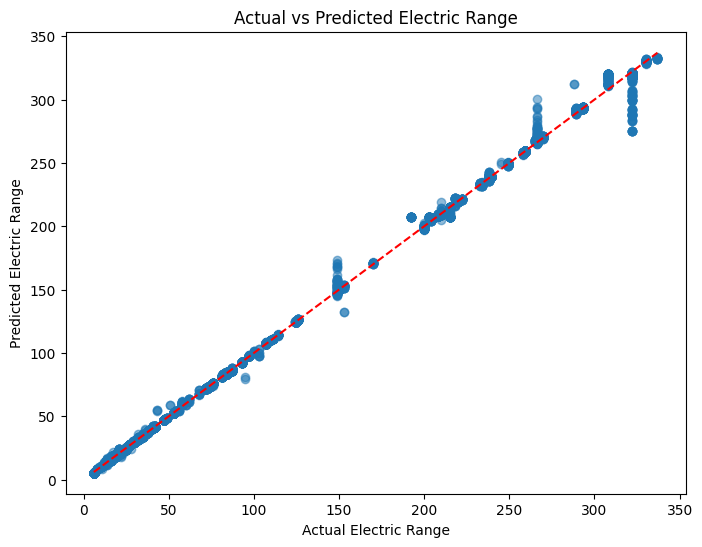

In [6]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Electric Range")
plt.ylabel("Predicted Electric Range")
plt.title("Actual vs Predicted Electric Range")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()


In [7]:
import numpy as np
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    mean_absolute_percentage_error
)

# Generate predictions for the entire test set
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.flatten()  # Convert to 1D array

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Additional metrics
median_ae = np.median(np.abs(y_test - y_pred))
max_error = np.max(np.abs(y_test - y_pred))
std_error = np.std(y_test - y_pred)

# Print comprehensive evaluation results
print("=" * 50)
print("MODEL EVALUATION METRICS")
print("=" * 50)
print(f"Mean Absolute Error (MAE): {mae:.2f} miles")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} miles")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"Median Absolute Error: {median_ae:.2f} miles")
print(f"Maximum Error: {max_error:.2f} miles")
print(f"Standard Deviation of Errors: {std_error:.2f} miles")

# Error analysis
residuals = y_test - y_pred
print("\n" + "=" * 40)
print("ERROR ANALYSIS")
print("=" * 40)
print(f"Mean Error (Bias): {np.mean(residuals):.2f} miles")
print(f"Error Range: [{np.min(residuals):.2f}, {np.max(residuals):.2f}] miles")

# Percentage of predictions within error thresholds
within_5 = np.sum(np.abs(residuals) <= 5) / len(residuals) * 100
within_10 = np.sum(np.abs(residuals) <= 10) / len(residuals) * 100
within_20 = np.sum(np.abs(residuals) <= 20) / len(residuals) * 100

print(f"\nPrediction Accuracy:")
print(f"Within ±5 miles: {within_5:.1f}%")
print(f"Within ±10 miles: {within_10:.1f}%")
print(f"Within ±20 miles: {within_20:.1f}%")

595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
MODEL EVALUATION METRICS
Mean Absolute Error (MAE): 0.67 miles
Mean Squared Error (MSE): 5.19
Root Mean Squared Error (RMSE): 2.28 miles
R-squared (R²): 0.9995
Mean Absolute Percentage Error (MAPE): 0.85%
Median Absolute Error: 0.28 miles
Maximum Error: 46.94 miles
Standard Deviation of Errors: 2.28 miles

ERROR ANALYSIS
Mean Error (Bias): -0.01 miles
Error Range: [-34.72, 46.94] miles

Prediction Accuracy:
Within ±5 miles: 98.5%
Within ±10 miles: 99.1%
Within ±20 miles: 99.7%
